# Zermelo problem, example 2

We consider the Zermelo-type optimal control problem with loss control regions given by

\begin{equation}
\begin{array}{lcl}
     \text{minimize}&  &-x_1(8),\\[10pt]
     \text{subject to}& &  (x,u) \in \mathrm{AC}([0,8],\R^2) \times \mathrm{L}^\infty([0,8],\R), \\[6pt]
     & & \dot{x}_1(t) = x_2(t) + \cos(u(t)), \quad \text{a.e.\ } t\in [0,8], \\[6pt]
     & & \dot{x}_2(t) = \sin(u(t)), \quad \text{a.e.\ } t\in [0,8], \\[6pt]
     &  & x(0)=0_{\R^2}, \quad x_2(8)=4,  \\[6pt]
     &  & u(t) \in [-\frac{\pi}{2},\frac{\pi}{2}], \quad \text{a.e.\ } t\in [0,8],
     \\[6pt]
     &  &u \text{ is constant when } x \text{ is in the loss control regions }
     \{x \in \mathbb{R}^2 \mid 5 < x_1 < 10 \} \text{ and } \{x \in \mathbb{R}^2 \mid 20 < x_1 < 25 \}.
\end{array}
\end{equation}

## Reformulation for the direct method

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8) + \varepsilon\int_0^8 v^2(t)dt + \int_0^1 f_{NC}(x(t))u^2(t)dt, \\[0.5em]
        \dot{x}_1(t) = f_{C}(x(t))(x_2(t) + \cos(u(t))) + f_{NC}(x_2(t) + \cos(\lambda(t))), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = f_{C}(x(t))\sin(u(t)) + f_{NC}(x(t))\sin(\lambda(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        \dot{\lambda}(t) = f_{C}(x(t))v^2(t),  \; \text{for a.e. } t\in [0,8], \\[0.5em]

        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \in \mathbb{R}^2 \mid 5 < x_1 < 10 \} \text{ and } \{x \in \mathbb{R}^2 \mid 20 < x_1 < 25 \}
        \text{ are the loss control regions.}
    \end{array}
    \right.
$$

In [1]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures
using LaTeXStrings

In [2]:
mutable struct DirecTSS
    t; x1; x2 ; λ ; u ; xu ; xv ; p1 ; p2
end

mutable struct DirecttSol
    t; x1; x2 ; λ ; u ; v ; xu ; xv ; p1 ; p2 ; p3
end

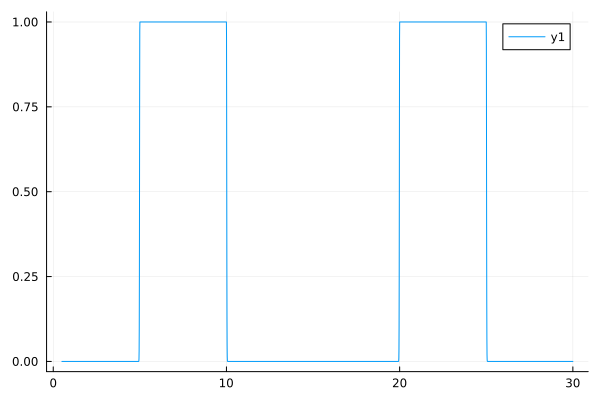

In [5]:
distance_squared(x, a, b) = x < a ? (a - x)^2 : x > b ? (x - b)^2 : 0 ;

#Moreau Yosida regularization

function MY_reg(x, a, b, k)
    return 1 - exp(-k*distance_squared(x, a, b))
end

fC(x)  = MY_reg(x, 5, 10, 2000) + MY_reg(x, 20, 25, 2000) - 1
fNC(x) = 1- fC(x)
plot(fNC, 0.5, 30)

In [9]:
function ZERMELO(ε=1e-3; x0=[0, 0], nsteps=1000, tol=1e-10, display=true)
    """
        Solve the Zermelo problem with the given parameters.

        Parameters
        ----------

        x0 : array of floats
            Initial condition
        nsteps : int
            Number of steps in the discretization
        ε : float
            Regularization parameter
        tol : float
            Tolerance for the solver
        display : bool
            If true, display the results

        Returns
        -------
        
        sol : DirecttSol
            The (direct) solution of the problem

    """

    # Create JuMP model, using Ipopt as the solver
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => display ? 5 : 1))
    set_optimizer_attribute(sys,"tol", tol)
    set_optimizer_attribute(sys,"constr_viol_tol", tol)
    set_optimizer_attribute(sys,"max_iter", 200)
    
    # Constants
    N  = nsteps     # Grid size
    
    # Variables
    @variables(sys, begin
        x1[1:N+1]
        x2[1:N+1]
        -2  ≤  λ[1:N+1]  ≤ 2 # we add box constraints to help the convergence
        -2  ≤  u[1:N+1]  ≤ 2
        v[1:N+1]
        xv[1:N+1]
        xu[1:N+1]
    end)
    
    # Objective
    @NLobjective(sys, Min, -x1[N+1] + ε*xv[N+1] + xu[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0
        con_xv0, xv[1]   == 0
        con_x10, x1[1]   == x0[1]
        con_x20, x2[1]   == x0[2]
        con_x2f, x2[N+1] == 4
        end)
    
    # Expressions for the dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j] + fNC(x1[j])*cos(λ[j]) + fC(x1[j])*cos(u[j]))
    @NLexpression(sys, dx2[j = 1:N+1],         fNC(x1[j])*sin(λ[j]) + fC(x1[j])*sin(u[j]) )
    @NLexpression(sys,  dλ[j = 1:N+1], fC(x1[j])*v[j])
    @NLexpression(sys, dxv[j = 1:N+1], v[j]^2)
    @NLexpression(sys, dxu[j = 1:N+1], fNC(x1[j])*u[j]^2)
    
    # Dynamics with Crank-Nicolson scheme
    Δt = 8/(N+1)
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1]  + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    λ  = value.(λ)[:]
    u  = value.(u)[:]
    v  = value.(v)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t  = (0:N) * value.(Δt)
    
    # duals of the boundary constraints
    px10 = -dual(con_x10)
    px20 = -dual(con_x20)
    px30 = 0 # λ(0) is free
    px1f = 1
    px2f = dual(con_x2f) 
    px3f = 0 # λ(4) is free

    # duals of the dynamics
    px1 = -[ dual(con_dx1[i]) for i in 1:N ]
    px2 = -[ dual(con_dx2[i]) for i in 1:N ]
    px3 = -[ dual(con_dx3[i]) for i in 1:N ]

    # adjoint vectors
    p1 = [px10; (px1[1:N-1]+px1[2:N])/2; px1f]
    p2 = [px20; (px2[1:N-1]+px2[2:N])/2; px2f]
    p3 = [px30; (px3[1:N-1]+px3[2:N])/2; px3f]

    return DirecttSol(t, x1, x2, λ, u, v, xu, xv, p1, p2, p3)
        
end;

In [10]:
# Resolution
ε   = 1e-3
sol_direct = ZERMELO(ε);

Solving...


┌ Warning: Function fNC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fNC, 1, fNC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear /Users/ocots/.julia/packages/MathOptInterface/BlCD1/src/Nonlinear/operators.jl:430
┌ Warning: Function fC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fC, 1, fC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear /Users/ocots/.julia/packages/MathOptInterface/BlCD1/src/Nonlinear/operators.jl:430


This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.0.

Number of nonzeros in equality constraint Jacobian...:    32005
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    34000

Total number of variables............................:     7007
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2002
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5005
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 4.60e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 


  objective value = -30.360935471772216



xu = 0.001771704313920299
xv = 1.352987117576085


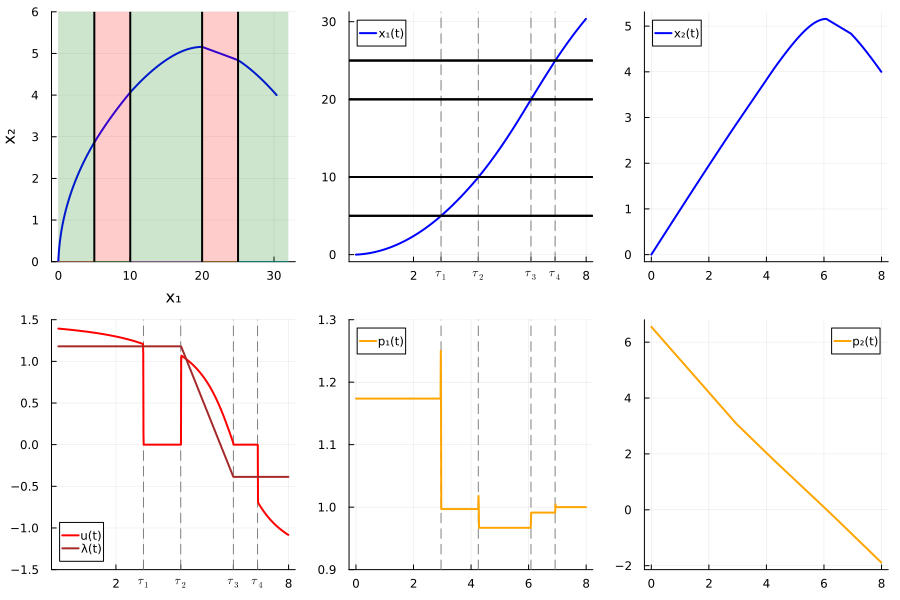

In [19]:
# Plots

t  = sol_direct.t
x1 = sol_direct.x1
x2 = sol_direct.x2
u  = sol_direct.u
v  = sol_direct.v
xu = sol_direct.xu
xv = sol_direct.xv
λ  = sol_direct.λ
p1  = sol_direct.p1
p2  = sol_direct.p2
p3  = sol_direct.p3

println("xu = ", xu[end])
println("xv = ", xv[end])

index1 = findfirst(abs.(x1.-  5.)  .<= 0.02)
index2 = findfirst(abs.(x1.- 10.)  .<= 0.04)
index3 = findfirst(abs.(x1.- 20.)  .<= 0.05)
index4 = findfirst(abs.(x1.- 25.)  .<= 0.06)

t1 = t[index1]
t2 = t[index2]
t3 = t[index3]
t4 = t[index4]

u1   = deepcopy(u)
u1[t1  .<= t .<= t2] .= λ[div(index1 + index2, 2)]
u1[t3  .<= t .<= t4] .= λ[div(index3 + index4, 2)]

# plots
x1_plot   = plot(t, x1, label="x₁(t)", linecolor=:blue, linewidth=2)
xticks!(x1_plot, [2.,t1,t2,t3,t4,8.], ["2",L"$\tau_1$",L"$\tau_2$",L"$\tau_3$",L"$\tau_4$","8"])
vline!(x1_plot, [t1], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(x1_plot, [t2], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(x1_plot, [t3], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(x1_plot, [t4], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
hline!([(0., 5), (31., 5)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 10), (31., 10)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 20), (31., 20)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 25), (31., 25)], linecolor=:black, linewidth=2, label=false)

x2_plot   = plot(t,  x2, label="x₂(t)", linecolor=:blue, linewidth=2)

p1_plot   = plot(t, p1, label="p₁(t)", linecolor=:orange, linewidth=2, ylims=(0.9, 1.3))
vline!(p1_plot, [t1], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(p1_plot, [t2], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(p1_plot, [t3], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(p1_plot, [t4], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)

p2_plot   = plot(t,  p2, label="p₂(t)", linecolor=:orange, linewidth=2)

u_plot = plot(t,  u, label="u(t)" ,linecolor=:red ,linewidth=2, ylims=(-1.5, 1.5))
plot!(t, λ, label="λ(t)", linecolor=:brown , linewidth=2)
xticks!(u_plot, [2.,t1,t2,t3,t4,8.], ["2",L"$\tau_1$",L"$\tau_2$",L"$\tau_3$",L"$\tau_4$","8"])
vline!(u_plot, [t1], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(u_plot, [t2], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(u_plot, [t3], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(u_plot, [t4], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)

x1x2_plot = plot(x1, x2, xlabel = "x₁", ylabel = "x₂",   legend=false, linecolor=:blue, linewidth=2)
plot!(x1x2_plot, [0.0, 5.],  [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
plot!(x1x2_plot, [5., 10.],  [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :red, label=false)
plot!(x1x2_plot, [10., 20.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
plot!(x1x2_plot, [20., 25.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :red, label=false)
plot!(x1x2_plot, [25., 32.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
vline!([5., 10., 20., 25.], linecolor=:black, linewidth=2, label=false)
ylims!(0, 6)

plot(x1x2_plot, x1_plot, x2_plot, u_plot, p1_plot, p2_plot , layout = (2,3), size=(900, 600))

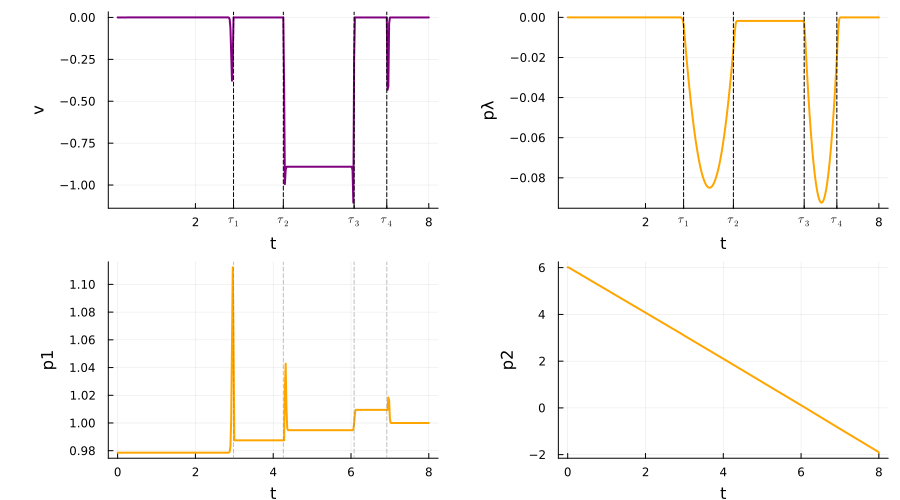

In [33]:
v_plot   = plot(t,  v, xlabel = "t", ylabel = "v",  legend=false,linecolor=:purple, linewidth=2)
xticks!(v_plot, [2.,t1,t2,t3,t4,8.], ["2",L"$\tau_1$",L"$\tau_2$",L"$\tau_3$",L"$\tau_4$","8"])
vline!(v_plot, [t1], linestyle=:dash, linecolor=:black, label=nothing)
vline!(v_plot, [t2], linestyle=:dash, linecolor=:black, label=nothing)
vline!(v_plot, [t3], linestyle=:dash, linecolor=:black, label=nothing)
vline!(v_plot, [t4], linestyle=:dash, linecolor=:black, label=nothing)

p3_plot   = plot(t,  p3, xlabel = "t", ylabel = "pλ",  legend=false,linecolor=:orange,linewidth=2)
xticks!(p3_plot, [2.,t1,t2,t3,t4,8.], ["2",L"$\tau_1$",L"$\tau_2$",L"$\tau_3$",L"$\tau_4$","8"])
vline!(p3_plot, [t1], linestyle=:dash, linecolor=:black, label=nothing)
vline!(p3_plot, [t2], linestyle=:dash, linecolor=:black, label=nothing)
vline!(p3_plot, [t3], linestyle=:dash, linecolor=:black, label=nothing)
vline!(p3_plot, [t4], linestyle=:dash, linecolor=:black, label=nothing)
plot(v_plot,p3_plot ,p1_plot,p2_plot, layout = (2,2), size=(900, 500), left_margin=10mm)

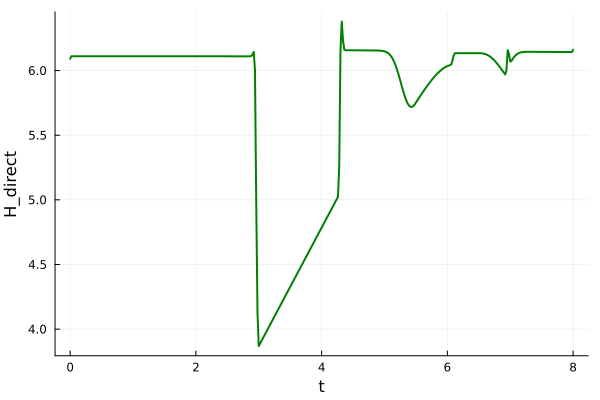

In [35]:
function H(k)
    return p1[k] *(fNC(x2[k])*(x2[k] + cos(λ[k])) + fC(x2[k])*(x2[k] + cos(u[k])))  + p2[k] * (fNC(x2[k])*sin(λ[k]) + fC(x2[k])*sin(u[k]) ) + fC(x2[k]) * p3[k] * v[k] - ε * (v[k])^2 - fNC(x2[k]) * (u[k])^2
end

H_direct  = [H(k) for k in 1:length(x1)]
ph_plot   = plot(t, H_direct, xlabel = "t", ylabel = "H_direct",  legend=false, linecolor=:green , linewidth=2)

In [9]:
#index1 = findfirst(abs.(x1.-  5.)  .<= 0.02)
#index2 = findfirst(abs.(x1.- 10.)  .<= 0.04)
#index3 = findfirst(abs.(x1.- 20.)  .<= 0.05)
#index4 = findfirst(abs.(x1.- 25.)  .<= 0.06)


In [37]:
jmp1 = p1[div(index1 + index2, 2)] - p1[div(index1 + 1, 2)]
jmp2 = p1[div(index2 + index3, 2)] - p1[div(index1 + index2, 2)]
jmp3 = p1[div(index3 + index4, 2)] - p1[div(index2 + index3, 2)]
jmp4 = p1[div(index4 + length(t), 2)] - p1[div(index3 + index4, 2)]

-0.009460645068234408

# Indirect method

In [38]:
using NLsolve
using Plots
using Plots.PlotMeasures
using Animations
using Reel
include("flow.jl");
using LinearAlgebra;

In [39]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

function G(λ)
    return [  sin(λ), - cos(λ) ]
end

# Hamiltonians: permanent region
H1(x, u, p)  = p' * F(x, u)                               # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])
Hc(x, p)     = H1(x, u11(x, p) , p )                      # control

# Flows
fc  = Flow(Hc);

# Hamiltonians: control loss region 1
H2(x, a, y, p)   = p' * F(x, a)   + y* p' *G(a)           # pseudo-Hamiltonian
Hcl1(X, P)       = H2(X[1:2], X[3], X[4], P[1:2])         # control loss1

fcl1  = Flow(Hcl1);

# Hamiltonians: control loss region 1
H3(x, b, y, p)   = p' * F(x, b)   + y* p' *G(b)           # pseudo-Hamiltonian
Hcl2(X, P)       = H3(X[1:2], X[3], X[4], P[1:2])         # control loss2

# Flows
fcl2  = Flow(Hcl2);

In [40]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]


# Shooting function
function shoot(p0, tt1, tt2, tt3, tt4, a1, b1, j1, j2, j3, j4) 
    
    pa0    = 0.0 
    pb0    = 0.0 
    py0    = 0.0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    
    
    X2, P2 = fcl1(tt1, [x1; a1 ; 0.0], [p1- [j1 , 0.]; pa0 ; py0], tt2) 
    
    
    x3, p3 = fc(tt2, X2[1:2], P2[1:2] - [j2 , 0.], tt3)
    

    X4, P4 = fcl2(tt3, [x3; b1 ; 0.0], [p3- [j3 , 0.]; pb0 ; py0], tt4)
    
 
    xf, pf = fc(tt4, X4[1:2], P4[1:2] - [j4 , 0.], tf)


    s = zeros(eltype(p0), 12)
    s[1]  = xf[2] - x2f   # target
    s[2]  = pf[1] - 1.0   # transversality condition
    s[3]  = x1[1] - 5.0   # first crossing 
    s[4]  = X2[1] - 10.0  # second crossing 
    s[5]  = x3[1] - 20.0  # first crossing 
    s[6]  = X4[1] - 25.0  # second crossing 
    s[7]  = P2[4]         # averaged gradient condition1
    s[8]  = P4[4]         # averaged gradient condition2
    s[9]   = j1 - (p1[1]*(cos(a1) - cos(u11(x1, p1))) + p1[2]*(sin(a1) - sin(u11(x1, p1))))/(x1[2] + cos(a1))                                              # jump 1
    s[10]  = j2 - (P2[1]*(cos(u11(x3, p3)) - cos(a1)) + P2[2]*(sin(u11(x3, p3)) - sin(a1)))/(X2[2]+cos(u11(x3, p3)))                                       # jump 2
    s[11]  = j3 - (p3[1]*(cos(b1) - cos(u11(x3, p3))) + p1[2]*(sin(b1) - sin(u11(x3, p3))))/(x3[2] + cos(b1))                                              # jump 3
    s[12]  = j4 - (P4[1]*(cos(u11(xf, pf)) - cos(b1)) + P4[2]*(sin(u11(xf, pf)) - sin(b1)))/(X4[2]+cos(u11(xf, pf)))                                       # jump 4

    
    return s

end;


In [41]:
S(ξ)    = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7], ξ[8], ξ[9], ξ[10], ξ[11], ξ[12]) ;

In [42]:
ξ_guess = [p1[1], p2[1], t1, t2,t3,t4, λ[div(index1+index2, 2)], λ[div(index3 + index4, 2)], jmp1, jmp2, jmp3, jmp4]; # initial guess


In [43]:
println("Initial value of shooting:\n", S(ξ_guess), "\n\n") ;

Initial value of shooting:
[0.11082533141787199, -0.04281038964774253, -0.00012907373765802532, -0.04143366803304005, -0.02562444044898271, 0.03401323484435537, 0.033198441862344524, 0.07516366256547684, 0.011800030300046425, 0.1882589548890561, 0.27022139700971465, 0.0043750172441361455]




In [44]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0 = indirect_sol.zero[1:2]
    tt1 = indirect_sol.zero[3]
    tt2 = indirect_sol.zero[4]
    tt3 = indirect_sol.zero[5]
    tt4 = indirect_sol.zero[6]
    a1  = indirect_sol.zero[7]
    b1  = indirect_sol.zero[8]
    j11 = indirect_sol.zero[9]
    j22 = indirect_sol.zero[10]
    j33 = indirect_sol.zero[11]
    j44 = indirect_sol.zero[12]
    
else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.702214e-01              NaN
     1     3.878298e-02     1.822243e+00
     2     4.374858e-04     1.654481e-02
     3     3.065968e-09     1.685278e-04
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.9785948051761287, 6.012457343014773, 2.98, 4.26, 6.08, 6.92, 1.1877015850158026, -0.3916994726736478, 0.008869143654744227, 0.00731382144442605, 0.014682874792935396, -0.009460645068234408]
 * Zero: [0.6413201256634131, 4.237210834043363, 2.9941757839207783, 4.28741179796846, 6.08516013820066, 6.926735512275274, 1.2449720399196027, -0.4147047136645246, -0.0011497726566664585, -0.19492925673930342, -0.15560972743784923, -0.006991117502768434]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4


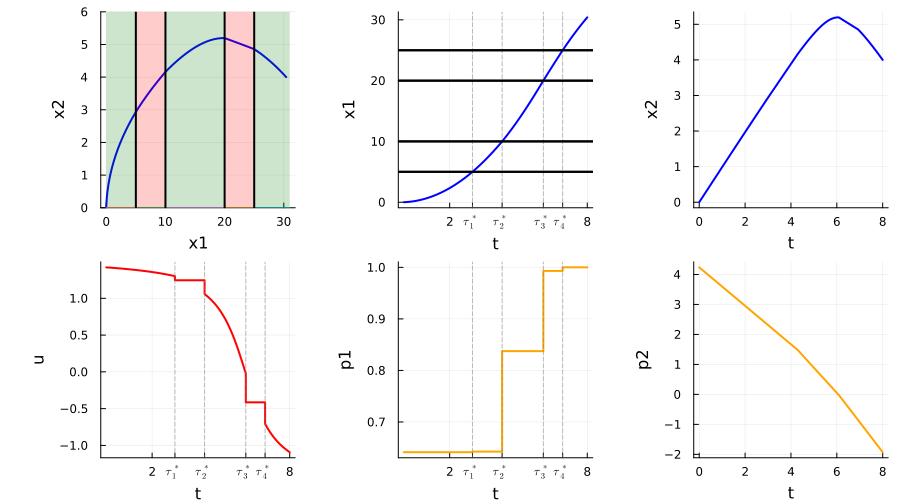

In [45]:
#Plots

pa0 = 0. 
pb0 = 0. 
py0 = 0.
pz0 = 0.


ode_sol = fc((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1    = ode_sol.t ;
xx1     = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1     = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1     = u11.(xx1, pp1)  ;



ode_sol = fcl1((tt1, tt2), [xx1[end] ; a1 ; 0.0], [pp1[end] - [ j11, 0.]; pa0 ; py0], saveat=0.1)
ttt2    = ode_sol.t
xx2     = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ]
pp2     = [ ode_sol[5:6, j] for j in 1:size(ttt2, 1) ]
uu2     = a1.*ones(length(ttt2)) ;


ode_sol = fc((tt2, tt3), xx2[end],  pp2[end] - [j22, 0.], saveat=0.1)
ttt3    = ode_sol.t
xx3     = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ]
pp3     = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] 
uu3     = u11.(xx3, pp3)  ;

ode_sol = fcl2((tt3, tt4), [xx3[end] ; b1 ; 0.0], [pp3[end] - [j33, 0.]; pb0 ; pz0], saveat=0.1)
ttt4    = ode_sol.t
xx4     = [ ode_sol[1:2, j] for j in 1:size(ttt4, 1) ]
pp4     = [ ode_sol[5:6, j] for j in 1:size(ttt4, 1) ] 
uu4     = b1.*ones(length(ttt4)) ;

ode_sol = fc((tt4, tf), xx4[end], pp4[end]- [j44, 0.], saveat=0.1)
ttt5 = ode_sol.t
xx5 = [ ode_sol[1:2, j] for j in 1:size(ttt5, 1) ]
pp5 = [ ode_sol[3:4, j] for j in 1:size(ttt5, 1) ] 
uu5 = u11.(xx5, pp5)  ;


t = [ ttt1 ; ttt2 ; ttt3 ; ttt4 ; ttt5]
x = [ xx1 ; xx2 ; xx3 ; xx4 ; xx5 ]
p = [ pp1 ; pp2 ; pp3 ; pp4 ; pp5 ]
u = [ uu1 ; uu2 ; uu3 ; uu4 ; uu5 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1,  xlabel = "t", ylabel = "x1", label=false,linecolor=:blue, linewidth=2)
xticks!(x1_plot, [2.,ttt1[end],ttt2[end],ttt3[end],ttt4[end],8.], ["2", L"$\tau^*_1$",L"$\tau^*_2$",L"$\tau^*_3$",L"$\tau^*_4$","8"])
vline!(x1_plot, [ttt1[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(x1_plot, [ttt2[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(x1_plot, [ttt3[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(x1_plot, [ttt4[end]], linestyle=:dash, linecolor=:gray, label=nothing)
hline!([(0., 5), (31., 5)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 10), (31., 10)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 20), (31., 20)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 25), (31., 25)], linecolor=:black, linewidth=2, label=false)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",label=false,linecolor=:blue,linewidth=2)

p1_plot   = plot(t,  p1,  xlabel = "t", ylabel = "p1",label=false,linecolor=:orange, linewidth=2)
xticks!(p1_plot, [2.,ttt1[end],ttt2[end],ttt3[end],ttt4[end],8.], ["2",L"$\tau^*_1$",L"$\tau^*_2$",L"$\tau^*_3$",L"$\tau^*_4$","8"])
vline!(p1_plot, [ttt1[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(p1_plot, [ttt2[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(p1_plot, [ttt3[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(p1_plot, [ttt4[end]], linestyle=:dash, linecolor=:gray, label=nothing)

p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", label=false,linecolor=:orange,linewidth=2)

u_plot    = plot(t,   u,  xlabel = "t", ylabel = "u", label=false , linecolor=:red ,linewidth=2) 
xticks!(u_plot, [2.,ttt1[end],ttt2[end],ttt3[end],ttt4[end],8.], ["2",L"$\tau^*_1$",L"$\tau^*_2$",L"$\tau^*_3$",L"$\tau^*_4$","8"])
vline!(u_plot, [ttt1[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(u_plot, [ttt2[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(u_plot, [ttt3[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(u_plot, [ttt4[end]], linestyle=:dash, linecolor=:gray, label=nothing)

x1x2_plot = plot(x1, x2,  xlabel = "x1", ylabel = "x2", label=false, linecolor=:blue,linewidth=2)
plot!(x1x2_plot, [0.0, 5.],  [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
plot!(x1x2_plot, [5., 10.],  [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :red, label=false)
plot!(x1x2_plot, [10., 20.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
plot!(x1x2_plot, [20., 25.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :red, label=false)
plot!(x1x2_plot, [25., 31.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
vline!([5., 10., 20., 25.], linecolor=:black, linewidth=2, label=false)
ylims!(0, 6)

plot(x1x2_plot, x1_plot, x2_plot, u_plot, p1_plot ,p2_plot , layout = (2,3), size=(900, 500), left_margin=10mm)

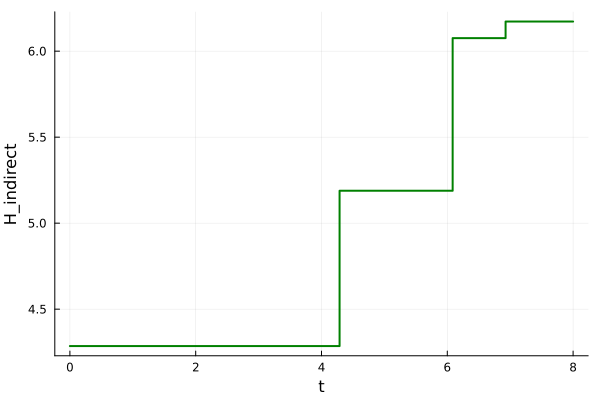

In [46]:
function HH(k)
    return p1[k] *(x2[k] + cos(u[k])) + p2[k] * sin(u[k])
end

H_indirect  = [HH(k) for k in 1:length(x2)]
ph_plot   = plot(t, H_indirect, xlabel = "t", ylabel = "H_indirect",  legend=false, linecolor=:green , linewidth=2)

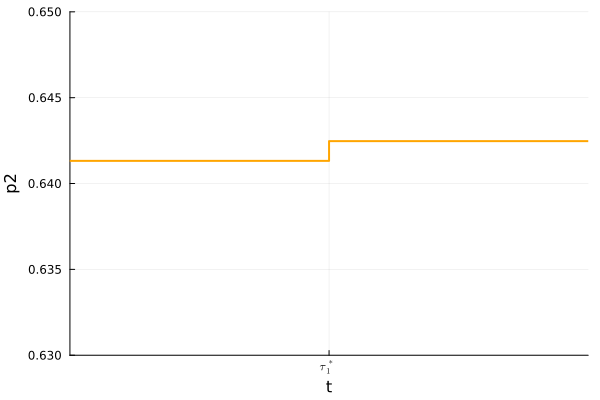

In [33]:
p1_plot = plot(t, p1, xlabel = "t", ylabel = "p2", legend=false, linecolor=:orange, linewidth=2)
xticks!(p1_plot, [2.,ttt1[end],ttt2[end],ttt3[end],ttt4[end],8.], ["2",L"$\tau^*_1$",L"$\tau^*_2$",L"$\tau^*_3$",L"$\tau^*_4$","8"])

xlims!(p1_plot, (ttt1[end]-0.01, ttt1[end]+0.01))
ylims!(p1_plot, (0.63,0.65))

In [19]:
# create an animation
animx = @animate for i = 1:length(t)
    plot(x1[1:i], x2[1:i], xlim=(0.,31.), ylim=(-0.,5.5), xlabel="x1", ylabel="x2", label="optimal trajectory \$x\$", linecolor=:blue,  linewidth=2)
    scatter!([x1[i]], [x2[i]], markersize=4, marker=:circle, color=:black, label=false)
    vline!([5., 10., 20., 25.], linecolor=:black, linewidth=2, label=false)
    plot!( [0.0, 5.],  [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
    plot!( [5., 10.],  [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :red, label=false)
    plot!( [10., 20.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
    plot!( [20., 25.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :red, label=false)
    plot!( [25., 31.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green, label=false)
end

# create an animation
animu = @animate for i = 1:length(t)
    plot(t[1:i], u[1:i], xlim=(0.,8.), ylim=(-pi/2,pi/2), xlabel="t", ylabel="u", label="opitmal control \$u\$", linecolor=:red,  linewidth=2)
end ;

# create an animation
animp1 = @animate for i = 1:length(t)
    plot(t[1:i], p1[1:i], xlim=(0.,8.), ylim=(-1.5, 1.5), xlabel="t", ylabel="p1", label="adjoint vector \$p1\$", linecolor=:orange,  linewidth=2)
end ;

# create an animation
animp2 = @animate for i = 1:length(t)
    plot(t[1:i], p2[1:i], xlim=(0.,8.), ylim=(-5.,0.5), xlabel="t", ylabel="p2", label="adjoint vector \$p2\$", linecolor=:orange,  linewidth=2)
end ;

[ Info: Saved animation to /home/anas/Documents/control-loss/zermelo/zer2_x.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/zermelo/zer2_x.gif")
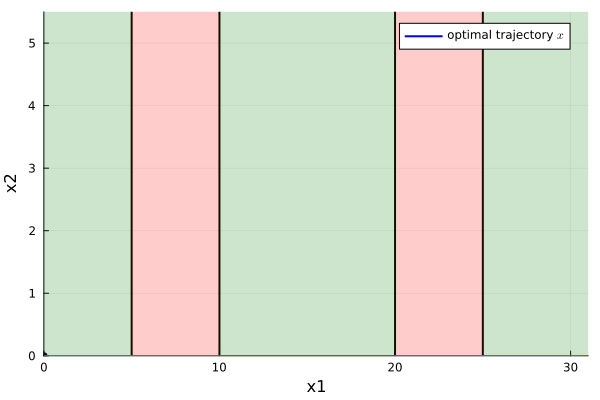

In [20]:
# display the animation
gif(animx, "zer2_x.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/zermelo/zer2_u.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/zermelo/zer2_u.gif")
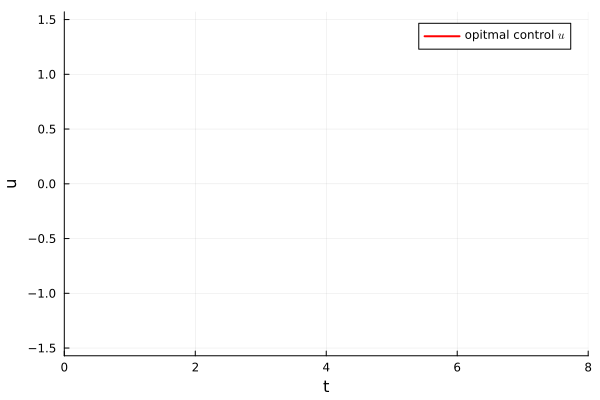

In [21]:
gif(animu, "zer2_u.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/zermelo/zer2_p1.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/zermelo/zer2_p1.gif")
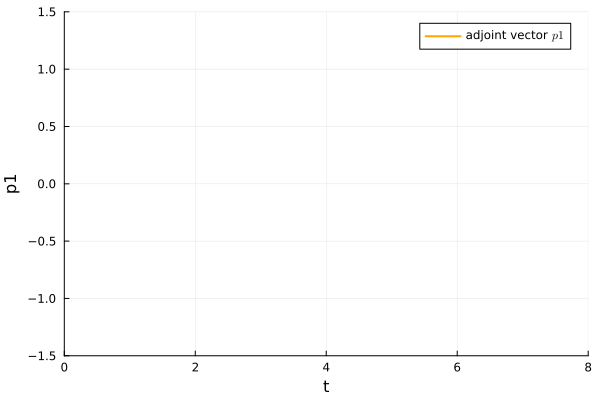

In [22]:
# display the animation
gif(animp1, "zer2_p1.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/zermelo/zer2_p2.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/zermelo/zer2_p2.gif")
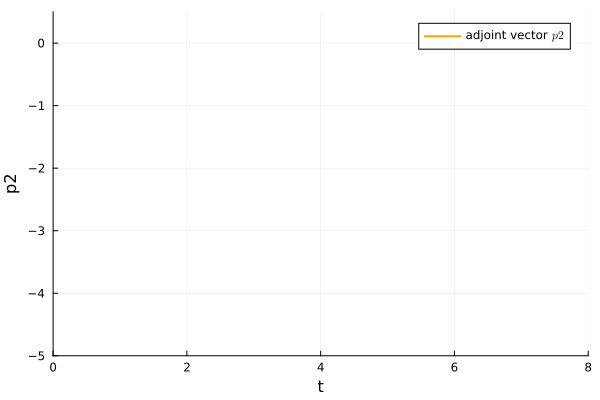

In [23]:
# display the animation
gif(animp2, "zer2_p2.gif", fps = 10)